In [1]:
!nvidia-smi

Wed Aug 25 15:13:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           On   | 00000000:65:00.0  On |                  N/A |
| 41%   36C    P8    20W / 280W |    697MiB / 24217MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
from glob import glob
import numpy as np
import nibabel as nib
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import Variable
from torchvision import transforms
import torch.nn as nn
from sklearn.metrics import roc_auc_score, average_precision_score
import tqdm
from operator import add

In [3]:
import easydict

In [4]:
dcm_path = '/home/chaeeun/MRI100_NECKTOFMRA/*'
nii_path = '/home/chaeeun/Desktop/brain disease prediction/MRI100_NECKTOFMRA_niis'

In [5]:
dcm_list_path = '/home/chaeeun/MRI100_NECKTOFMRA'
dcm_list =  os.listdir(dcm_list_path)
dcm_list.sort()

In [5]:
# #dcm --> nii code
# #for i, patient in enumerate(glob(dcm_path)):nonononononono
# for f in dcm_list:
#     dicom2nifti.dicom_series_to_nifti(dcm_list_path +'/'+ f, os.path.join(nii_path, f + '.nii.gz'))#nii_path에 파일 추가

In [96]:
# nib.save(sliced_data, '/home/chaeeun/Desktop/sliced_nii.nii.gz')#for checking well-sliced

In [6]:
nii_path = '/home/chaeeun/Desktop/brain disease prediction/MRI100_NECKTOFMRA_niis/'
files = os.listdir(nii_path)
files.sort()
files = files[1:]#ipynb_checkpoints file name remove...
len(files), files[0]

(100, '14090110_20180523_095025_MR.nii.gz')

In [8]:
data = []
for f in files:
    path = os.path.join(nii_path, f)
    img = nib.load(path)
    sliced_img = img.slicer[190:330, 220:350, 70:220]
    img = sliced_img.get_fdata()
    img = np.asarray(np.float32(img))
    img = img.reshape(1, 140, 130, 150)
    data.append(img)

In [9]:
len(data), type(data)

(100, list)

In [10]:
#torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.get_device_name(0), torch.cuda.current_device()

In [11]:
#to tensor& gpu
data = np.array(data, dtype='float32') 
# train_X = torch.from_numpy(data)

# train_X = train_X.type(torch.cuda.FloatTensor) #making a 32-floating point gpu tensor
# train_X.shape

In [12]:
label_data = pd.read_excel('/home/chaeeun/Desktop/brain disease prediction/100_Neuroquant5.xlsx') 
label_data

,FOLDERNAME,Cerebral WM Hypointensities* Total Percent Of Icv,Cortical Gray Matter Total Percent Of Icv,Ventricle Total Percent Of Icv,Cerebral White Matter Total Percent Of Icv,Whole Brain Total Percent Of Icv
0,14090110_20180523_095025_MR,0.0249,30.7874,1.9233,30.4758,75.8345
1,14152551_20180129_085254_MR,0.1131,31.9052,2.6646,30.7423,77.1605
2,15168092_20180223_091548_MR,0.1630,30.3495,3.3834,28.8604,71.4136
3,16657951_20180529_103505_MR,0.0740,30.7348,2.1675,31.3847,75.1116
4,16965739_20180419_103601_MR,0.0991,30.3336,2.2278,30.6224,75.7314
...,...,...,...,...,...,...
95,37754277_20180525_095533_MR,0.0419,32.1248,2.3468,31.0151,77.1214
96,37839123_20180323_083328_MR,0.0416,31.6745,2.4120,29.5286,75.8071
97,37843254_20180502_085729_MR,0.1920,32.0577,2.9788,27.7734,73.9830
98,38008559_20180223_105704_MR,0.0199,34.3086,1.7611,30.0620,77.9791


In [13]:
del label_data['FOLDERNAME']
label_data
label = label_data.to_numpy()
type(label)

numpy.ndarray

In [157]:
label[:,0]

array([0.0249, 0.1131, 0.163 , 0.074 , 0.0991, 0.0867, 0.0236, 0.0573,
       0.0319, 0.0074, 0.0673, 0.0102, 0.0949, 0.    , 0.0575, 0.0462,
       0.3219, 0.0147, 0.0765, 0.0266, 0.0463, 0.0886, 0.0065, 0.0397,
       0.0551, 0.0885, 0.0647, 0.0304, 0.9037, 0.2368, 0.0775, 1.1733,
       0.0644, 0.0824, 0.0395, 0.6179, 0.2291, 0.139 , 0.0161, 0.0306,
       0.244 , 0.0323, 0.0077, 0.0239, 0.0717, 0.0122, 0.0159, 0.0468,
       0.0505, 0.0477, 0.0079, 0.103 , 0.024 , 0.0843, 0.025 , 0.0246,
       0.0287, 0.0942, 0.0363, 0.0395, 0.0351, 0.0151, 0.0091, 0.0152,
       0.1567, 0.2033, 0.2524, 0.0365, 0.0365, 0.0275, 0.0377, 0.0413,
       0.    , 0.0785, 0.0355, 0.0617, 0.0279, 0.0115, 0.0376, 0.008 ,
       0.0503, 0.0799, 0.0213, 0.0768, 0.01  , 0.072 , 0.0098, 0.1616,
       0.0608, 0.0766, 0.0802, 0.0807, 0.0229, 0.0536, 0.067 , 0.0419,
       0.0416, 0.192 , 0.0199, 0.052 ], dtype=float32)

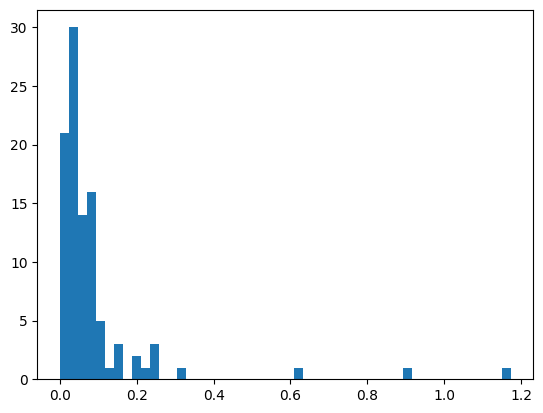

mean:  0.08845101
std:  0.15947312


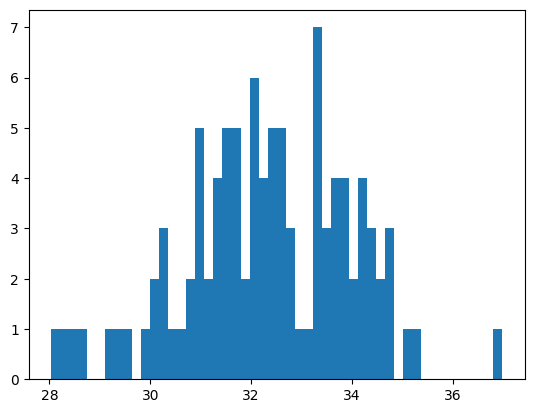

mean:  32.306248
std:  1.6707758


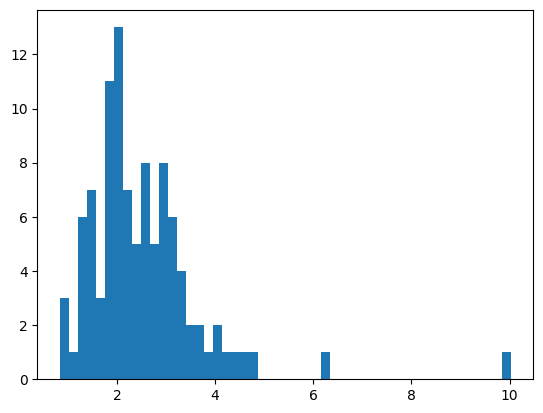

mean:  2.516097
std:  1.1953615


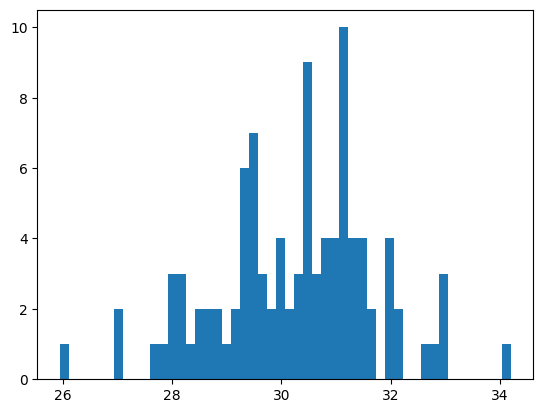

mean:  30.239126
std:  1.4485773


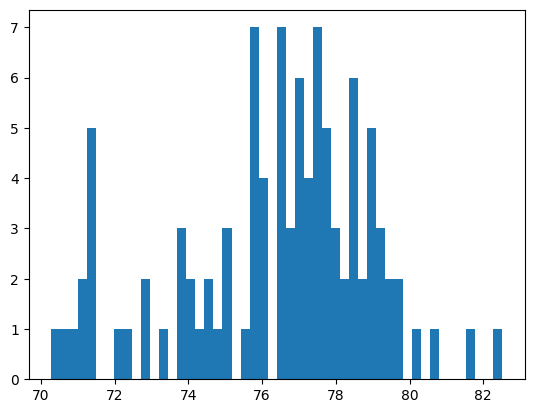

mean:  76.38823
std:  2.5952046


In [230]:
for i in range(5):
    plt.hist(label[:,i], bins = 50)
    plt.show()
    print("mean: ", label[:,i].mean())
    print("std: ",label[:, i].std())

In [176]:
max(label[:,1])

36.9758

In [14]:
label = np.array(label, dtype = 'float32')

len(label), type(label)


(100, numpy.ndarray)

In [124]:
X_train = data[:75]
X_test = data[75:]
y_train = label[:75]
y_test = label[75:]

In [125]:
len(X_train), len(X_test), len(y_train), len(y_test)
type(X_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

In [126]:
datadict = {'X_train': X_train,
           'y_train' : y_train,
           'X_test': X_test,
            'y_test': y_test
           }

In [127]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [128]:
class mridataset(Dataset):
    def __init__(self, data, data_type):
        if data_type == 'train':
            self.X = data['X_train']
            self.y = data['y_train']
        elif data_type == 'test':
            self.X = data['X_test']
            self.y = data['y_test']
            
        assert len(self.X) == len(self.y), "length should be same between input and label"
        
        self.X = torch.FloatTensor(self.X)#cpu tensor
        self.y = torch.FloatTensor(self.y)#cpu tensor
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return {
            'X': X,
            'y_target': y
        }

In [129]:
os.getcwd()

'/home/chaeeun/Desktop/brain disease prediction'

In [ ]:
###############################practice###############learning about __getitem__

In [23]:
exampledataset = mridataset(datadict, data_type = 'test')

In [27]:
len(exampledataset), type(exampledataset),exampledataset

(20, __main__.mridataset, <__main__.mridataset at 0x7f1f28b1f190>)

In [31]:
exampledataset[9]['X'].shape, exampledataset[9]['y_target'].shape

(torch.Size([1, 140, 130, 150]), torch.Size([5]))

In [ ]:
######################################################

#trainset done...!

In [130]:
#<<resnet 3d>>
#마지막의 fully connected part는 2d 부분의 코드들을 참고해서 만들것!!

In [256]:
import math
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F


def get_inplanes():
    return [64, 128, 256, 512]


def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)


def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=1,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=5):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(self._downsample_basic_block,
                                     planes=planes * block.expansion,
                                     stride=stride)
            else:
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model

In [280]:
# model.cuda()#모델도 gpu로
model = generate_model(18)
model.to(device)

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [284]:
config = easydict.EasyDict({'n_epoch': 25,
                           'batch_size': 8,
                           'lr': 1e-3,
                           'save_dir':'./',
                           'dropout' : 0.3,
                            'modelname' : 'resnet18'
                           })

In [285]:
train_loader = DataLoader(mridataset(datadict, data_type = 'train'), batch_size = config.batch_size, num_workers = 8, shuffle = True)
#num_workers: cpu 여러개로 학습을 시켜라(8)
test_loader = DataLoader(mridataset(datadict, data_type = 'test'), batch_size = config.batch_size, num_workers = 8, shuffle = False)

In [286]:
len(train_loader)

10

In [287]:
#save&load path
filename = f'Model_{config.modelname}_batch_{config.batch_size}_lr_{config.lr}'
output_path = os.path.join(config.save_dir, filename)
print('Model will be saved in {}'.format(output_path))

Model will be saved in ./Model_resnet18_batch_8_lr_0.001


In [288]:
#Loss
criterion = nn.MSELoss()
criterion2 = nn.L1Loss()
#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)

In [289]:
# y_target

In [290]:
# y_pred

In [291]:
#trainer
loss_plot, val_loss_plot = [], []
maeloss_plot, maeval_loss_plot = [], []
y_each_maeloss_plot = []
for n_epoch in range(1, config.n_epoch + 1):
    print(f'Train Epoch {n_epoch} start!')
    avg_train_loss = 0
    avg_train_mae = 0
#     y1_mae = 0, y2_mae = 0, y3_mae = 0, y4_mae = 0, y5_mae = 0
    
    model.train()
    
    for iter, batch in enumerate(train_loader):
        X = batch['X'].to(device)
        y_target = batch['y_target'].to(device)
        optimizer.zero_grad()#optimizer reset
        
        y_pred = model(X)
        loss = criterion(y_pred, y_target)
        loss2 = criterion2(y_pred, y_target)


        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item() / len(train_loader)
        avg_train_mae += loss2.item() / len(train_loader)

        
        
    print('[Train] loss: {:.3f}'.format(avg_train_loss))
    print('[Train] mae_loss: {:.3f}'.format(avg_train_mae))
    loss_plot.append(avg_train_loss)
    maeloss_plot.append(avg_train_mae)
        #evaluation
    model.eval()
    avg_test_loss = 0
    avg_test_mae = 0
    y_each = [0]*5
        
    with torch.no_grad(): #no need to compute gradient

        for iter, batch in enumerate(test_loader):
            X = batch['X'].to(device)
            y_target = batch['y_target'].to(device)
                
            y_pred = model(X)
            loss = criterion(y_pred, y_target)
            loss2 = criterion2(y_pred, y_target)
            y_each_maeloss = []
            for i in range(5):
                y_each_maeloss.append(criterion2(y_pred[0][i], y_target[0][i]).item() / len(train_loader))    

            y_each = list(map(add, y_each, y_each_maeloss))
            avg_test_loss += loss.item()/len(test_loader)
            avg_test_mae += loss2.item()/len(test_loader)

        print('[Test]  loss: {:.3f}'.format(avg_test_loss))
        print('[Test]  mae_loss: {:.3f}'.format(avg_test_mae))
        print('[Test, y_each_maeloss]: ',y_each)
        print('\n')
        val_loss_plot.append(avg_test_loss)
        maeval_loss_plot.append(avg_test_mae)
        y_each_maeloss_plot.append(y_each)

Train Epoch 1 start!
[Train] loss: 1343.308
[Train] mae_loss: 25.936
[Test]  loss: 662.815
[Test]  mae_loss: 20.312
[Test, y_each_maeloss]:  [0.16178924217820168, 13.193943214416505, 8.634934997558595, 8.443574714660645, 5.1874229431152346]


Train Epoch 2 start!
[Train] loss: 1012.011
[Train] mae_loss: 21.880
[Test]  loss: 774.320
[Test]  mae_loss: 18.138
[Test, y_each_maeloss]:  [0.03840316161513328, 5.986505794525146, 0.30100330114364626, 6.3969118118286135, 22.49895401000977]


Train Epoch 3 start!
[Train] loss: 745.683
[Train] mae_loss: 17.850
[Test]  loss: 638.622
[Test]  mae_loss: 15.868
[Test, y_each_maeloss]:  [0.11502802670001984, 4.360010719299316, 0.4179733395576477, 4.796970367431641, 20.82328071594238]


Train Epoch 4 start!
[Train] loss: 517.476
[Train] mae_loss: 13.592
[Test]  loss: 452.812
[Test]  mae_loss: 12.042
[Test, y_each_maeloss]:  [0.10668722987174986, 2.0230037689208986, 0.30341712236404417, 2.5420572280883786, 17.9918643951416]


Train Epoch 5 start!
[Train] 

In [271]:
from operator import add
x = [0, 0, 0, 0, 0]
y = [1, 1, 5, 1, 1]
z=list(map(add, x, y))
print(z)

[1, 1, 5, 1, 1]


In [305]:
# loss = criterion(y_pred, y_target)
y_plot = np.array(y_each_maeloss_plot, np.float32)
y_plot.shape

(25, 5)

In [148]:
# y_pred
# loss = criterion(y_pred, y_target)
print(loss.item())
# loss2 = criterion2(y_pred, y_target)
print(loss2.item())

y_pred[0]

15.383448600769043
3.069242238998413


tensor([3.7306e-02, 2.9708e+01, 3.1115e+00, 2.8314e+01, 7.1264e+01],
       device='cuda:0')

In [84]:
len(loss_plot), len(val_loss_plot)

(29, 29)

In [31]:
import matplotlib.pyplot as plt

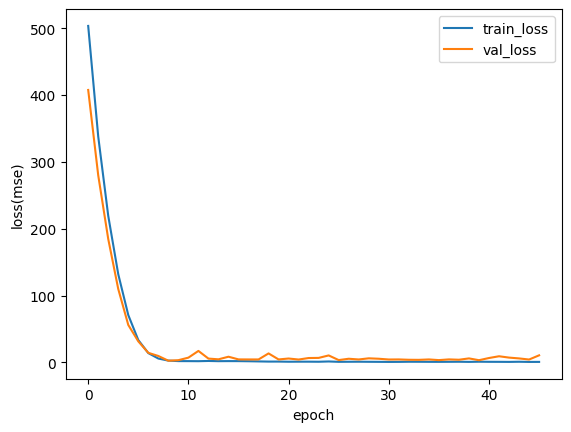

In [144]:
plt.plot(loss_plot[3:], label='train_loss')
plt.plot(val_loss_plot[3:], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mse)')
plt.legend()
plt.show()

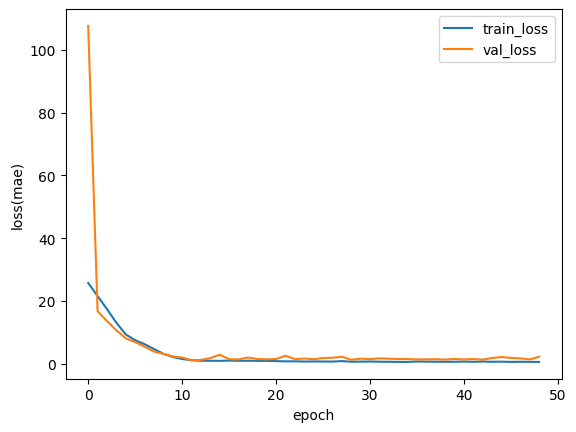

In [145]:
plt.plot(maeloss_plot, label='train_loss')
plt.plot(maeval_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mae)')
plt.legend()
plt.show()

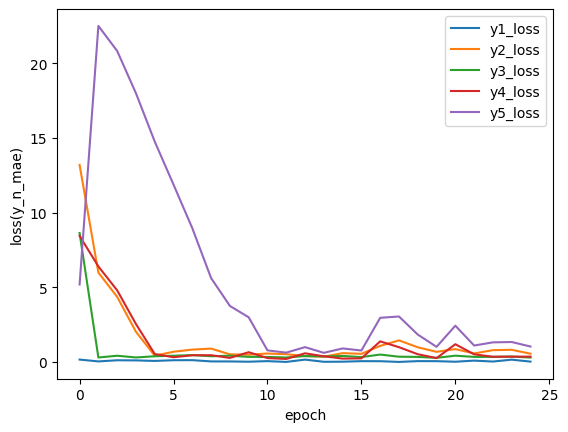

In [306]:
plt.plot(y_plot[:,0], label='y1_loss')
plt.plot(y_plot[:,1], label='y2_loss')
plt.plot(y_plot[:,2], label='y3_loss')
plt.plot(y_plot[:,3], label='y4_loss')
plt.plot(y_plot[:,4], label='y5_loss')

plt.xlabel('epoch')
plt.ylabel('loss(y_n_mae)')
plt.legend()
plt.show()

In [146]:
torch.save(model, output_path)